# DA9 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA9'
subj_format = ['nlx']
subj_site = ['UCD']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 44 x 7200008 (14400.0 s), ~2.36 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 7200008 (14400.0 s), ~54.9 MB, data loaded>

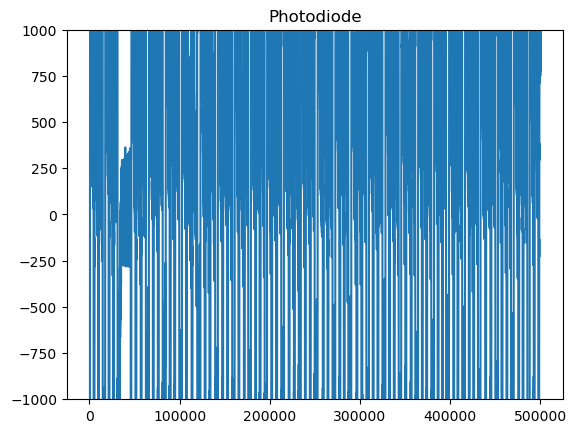

In [51]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,4000000:4500000])
plt.title("Photodiode")
plt.ylim(-1000,1000)
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAD1,mAmyg_L,-17.471760,10.790956,-9.888621,-14.202810,-3.822049,-19.553816,Gray,Left Amygdala,Amygdala (SF),L ParaHippocampal Gyrus,L Amyg,Left parahippocampal gyrus A,NaN
1,LAD2,mAmyg_L,-22.261112,10.391291,-9.089589,-19.216283,-3.891958,-19.043659,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
2,LAD3,mAmyg_L,-27.449577,10.391291,-8.690073,-24.550816,-3.667518,-19.122501,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
3,LAD4,lAmyg_L,-32.238930,9.991626,-8.290558,-29.505896,-3.881665,-19.126831,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN
4,LAD5,Unknown,-37.427395,9.591962,-7.491526,-34.980580,-3.964504,-18.722788,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,A38l_L,-42.216747,9.192297,-7.092010,-40.067985,-4.078986,-18.697161,Gray,Left PP planum polare,Area Id1,Unknown,L STG,Left superior temporal gyrus A,NaN
6,LAD7,A22r_L,-47.405212,8.792632,-6.292979,-45.629547,-4.036446,-18.194110,Gray,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L STG,Left superior temporal gyrus B,NaN
7,LAD8,aSTS_L,-52.194565,8.792632,-5.493947,-50.795900,-3.681195,-17.772288,Gray,Left STG superior temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior temporal gyrus B,NaN
8,LFP1,A11m_L,-19.068211,44.362791,-1.498790,-13.605498,34.223324,-16.416872,White,Left Cerebral White Matter,Area Fo1,L Rectal Gyrus,L OrG,Unknown,WM
9,LFP2,Unknown,-19.866436,42.364467,2.895883,-15.002357,33.627828,-10.932631,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,45.0,mix,458.262575,458.273875,462.041225,462.049006,3.767350,0.0,-1.10,...,-0.482018,0.708935,0.291065,0.000000,0.482018,0.482018,0.000000,0.000000,0.482018,0.482018
1,2,146.0,loss,468.814804,468.828686,473.819151,473.826753,4.990465,-0.6,-1.68,...,-0.903787,0.158584,0.841416,0.000000,-0.392050,-0.392050,-0.392050,-0.392050,0.000000,0.000000
2,3,140.0,loss,480.509956,480.510710,484.830998,484.838941,4.320288,-0.5,-2.50,...,-1.630484,0.012847,0.987153,0.000000,1.331392,1.331392,0.000000,0.000000,1.331392,1.331392
3,4,57.0,gain,497.135665,497.142355,500.407262,502.416627,3.264907,0.2,0.00,...,0.000000,0.627649,0.372351,0.000000,0.000000,0.160115,0.000000,0.000000,0.251834,0.160115
4,5,47.0,mix,507.397588,507.406724,511.335869,511.343683,3.929145,0.0,-1.10,...,-0.482018,0.975484,0.024516,0.000000,0.482018,0.482018,0.000000,0.000000,0.482018,0.482018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,127.0,loss,2211.392241,2211.392976,2214.280426,2214.288188,2.887450,-0.4,-1.26,...,-0.589670,0.227479,0.772521,0.000000,-0.214760,-0.214760,-0.214760,-0.214760,0.000000,0.000000
146,147,78.0,gain,2220.904660,2220.905430,2225.208157,2227.218260,4.302726,0.4,0.00,...,0.000000,0.877038,0.122962,-0.859095,-0.859095,-0.256628,-0.859095,-0.256628,0.000000,0.000000
147,148,85.0,gain,2236.130865,2236.138261,2238.452797,2240.478945,2.314536,0.5,0.00,...,0.000000,0.746189,0.253811,0.000000,0.000000,0.330687,0.000000,0.000000,0.688088,0.330687
148,149,148.0,loss,2245.193557,2245.194353,2247.982401,2247.990169,2.788048,-0.6,-2.16,...,-1.312437,0.047361,0.952639,0.000000,0.920388,0.920388,0.000000,0.000000,0.920388,0.920388


In [10]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [11]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=1)

30 blocks
..............................

found matches for 60 of 459 pulses
22 blocks
......................

found matches for 40 of 459 pulses


In [12]:
print(slope, offset)

1.714625706487987 5831.579914263282


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [17]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 5910 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 6600 out of 6600 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 6506 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 6600 out of 6600 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks     

In [18]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~75.6 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~126.0 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [19]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [20]:
epochs_all_evs[event].metadata

,ril7,ril6,rfp9,lhd9,lhd2,rfp2,rfp3,lfp1,lfp7,lfp6,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,[1990],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.32,-1.32,0.00,0.0,1.10,1.10,0.272985,0.000000
1,NaN,NaN,NaN,[1981],NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,-0.60,-0.6,0.00,0.00,-0.903787,-0.392050
2,[1047],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.50,-0.50,0.00,0.0,2.00,2.00,-1.630484,-0.299093
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.315,0.315,0.00,0.43,0.00,0.0,0.63,0.43,0.251834,0.091719
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-2.20,-2.20,0.00,0.0,1.10,1.10,1.129583,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.40,-0.40,-0.40,-0.4,0.00,0.00,-0.589670,-0.214760
146,NaN,NaN,NaN,NaN,[1880],NaN,NaN,NaN,NaN,NaN,...,0.720,-0.720,-1.44,-0.40,-1.44,-0.4,0.00,0.00,0.859095,0.256628
147,NaN,NaN,NaN,NaN,[1573],NaN,NaN,NaN,NaN,NaN,...,0.620,0.620,0.00,0.74,0.00,0.0,1.24,0.74,0.688088,0.357401
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.0,1.56,1.56,-1.312437,-0.392050


### Save epoched data

In [21]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)